In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('xy_day.csv', 
    dtype={'taxi_id':int, 'location_id':int, 'date_time':object, 'x':float, 'y':float}, 
    parse_dates=['date_time'], 
    infer_datetime_format=True)
loc = pd.read_csv('xy_loc.csv')
def mean_absolute_error(freq, est_freq):
    return (abs(freq - est_freq)).mean()
def mean_relative_error(freq, est_freq):
    freq /= freq.sum()
    est_freq /= est_freq.sum()
    return (abs(freq - est_freq)/(freq + np.finfo(np.float32).eps)).mean()
def jaccard_index(freq, est_freq, k):
    top_k = np.argpartition(-freq, k)[:k]
    est_top_k = np.argpartition(-est_freq, k)[:k]
    return len(np.intersect1d(top_k, est_top_k))/len(np.union1d(top_k, est_top_k))
def MSE(freq, est_freq):
    return (np.square(freq - est_freq)).mean()
def RMSE(freq, est_freq):
    return np.sqrt((np.square(freq - est_freq)).mean())
import numpy as np
from math import exp

from tqdm import trange

n = 10357
episode = 1440
d = 900
universe = np.arange(d)

interval = pd.Timedelta('1min')
current_time = pd.Timestamp('2008-02-02 13:30:00')

w = 30
epsilon = 1
epsilon_range = np.arange(0.1, 1.1, 0.1)
w_range = np.arange(5, 85, 5)

In [2]:
current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = pd.Timedelta('1min')

uniform_util = []
uniform_js_util = []
for t in range(episode):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.location_id] += 1
        # randomization
        release_budget = epsilon/(w)
        exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
        exp_prob = np.exp(-release_budget*exp_prob/2)
        exp_prob /= exp_prob.sum()
        private_loc = np.random.choice(universe, p=exp_prob)
        private_freq[private_loc] += 1
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    uniform_js_util.append(jaccard_index(true_freq, private_freq, 50))
    uniform_util.append(RMSE(true_freq, private_freq))

In [3]:
window = np.zeros((n, episode), dtype=float)
# current window pointer
cwp = 0
# historical data
storage = [[] for _ in range(n)]

current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = pd.Timedelta('1min')

sample_util = []
sample_js_util = []
for t in range(episode):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.location_id] += 1
        # randomization
        release_budget = epsilon
        remain = epsilon - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
        if remain < release_budget:
            release_budget = 0
        if release_budget:
            exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
            exp_prob = np.exp(-release_budget*exp_prob/2)
            exp_prob /= exp_prob.sum()
            private_loc = np.random.choice(universe, p=exp_prob)
            # update window
            window[row.taxi_id-1][cwp] = release_budget
            storage[row.taxi_id-1].append(private_loc)
        else:
            private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
        private_freq[private_loc] += 1
    cwp += 1
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    sample_js_util.append(jaccard_index(true_freq, private_freq, 50))
    sample_util.append(RMSE(true_freq, private_freq))

In [4]:
window = np.zeros((n, episode), dtype=float)
# current window pointer
cwp = 0
# historical data
storage = [[] for _ in range(n)]
# adaptive allocation parameter
c = np.full(n, 0.45)
data_flag = np.zeros((n, episode), dtype=int)
release_flag = np.zeros((n, episode), dtype=int)
pid_error = np.zeros((n, episode), dtype=float)

current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = pd.Timedelta('1min')

ada_util = []
ada_js_util = []
for t in range(episode):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.location_id] += 1
        data_flag[row.taxi_id-1][cwp] = 1
        # randomization
        release_budget = epsilon/(w*c[row.taxi_id-1])
        remain = epsilon - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
        if remain < release_budget:
            release_budget = 0
        if release_budget:
            exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
            exp_prob = np.exp(-release_budget*exp_prob/2)
            exp_prob /= exp_prob.sum()
            private_loc = np.random.choice(universe, p=exp_prob)
            # update window
            window[row.taxi_id-1][cwp] = release_budget
            storage[row.taxi_id-1].append(private_loc)
            release_flag[row.taxi_id-1][cwp] = 1
        else:
            private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
        private_freq[private_loc] += 1
    if t > 30:
        data_num = data_flag[:, max(0, cwp-w+1):cwp].sum(axis=1)
        release_num = release_flag[:, max(0, cwp-w+1):cwp].sum(axis=1)
        pid_error[:, cwp] = abs((data_num - (release_num + 0.001))/w)
        # pid_error[:, t] = abs(pid_error[:, t-1] - data_num/w)
        error = np.sign(pid_error[:, t])*(0.5*pid_error[:, cwp] + 0.0*pid_error[:, max(0, cwp-w+1):cwp].sum(axis=1)/min(w, cwp) + 0.0*(pid_error[:, cwp] - pid_error[:, cwp-1]))
        c = np.clip(c + error, 1/w, 1)
    cwp += 1
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    ada_js_util.append(jaccard_index(true_freq, private_freq, 50))
    ada_util.append(RMSE(true_freq, private_freq))

In [ ]:
window = np.zeros((n, episode), dtype=float)
# current window pointer
cwp = 0
# historical data
storage = [[] for _ in range(n)]
# adaptive allocation parameter
c = np.full(n, 0.45)
data_flag = np.zeros((n, episode), dtype=int)
release_flag = np.zeros((n, episode), dtype=int)
pid_error = np.zeros((n, episode), dtype=float)

current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = pd.Timedelta('1min')

fix_util = []
fix_js_util = []
for t in range(episode):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.location_id] += 1
        data_flag[row.taxi_id-1][cwp] = 1
        # randomization
        release_budget = epsilon/(w*c[row.taxi_id-1])
        remain = epsilon - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
        if remain < release_budget:
            release_budget = 0
        if release_budget:
            exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
            exp_prob = np.exp(-release_budget*exp_prob/2)
            exp_prob /= exp_prob.sum()
            private_loc = np.random.choice(universe, p=exp_prob)
            # update window
            window[row.taxi_id-1][cwp] = release_budget
            storage[row.taxi_id-1].append(private_loc)
            release_flag[row.taxi_id-1][cwp] = 1
        else:
            private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
        private_freq[private_loc] += 1
    # if t > 30:
    #     data_num = data_flag[:, max(0, cwp-w+1):cwp].sum(axis=1)
    #     release_num = release_flag[:, max(0, cwp-w+1):cwp].sum(axis=1)
    #     pid_error[:, cwp] = abs((data_num - (release_num + 0.001))/w)
    #     # pid_error[:, t] = abs(pid_error[:, t-1] - data_num/w)
    #     error = np.sign(pid_error[:, t])*(0.5*pid_error[:, cwp] + 0.0*pid_error[:, max(0, cwp-w+1):cwp].sum(axis=1)/min(w, cwp) + 0.0*(pid_error[:, cwp] - pid_error[:, cwp-1]))
    #     c = np.clip(c + error, 1/w, 1)
    cwp += 1
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    fix_js_util.append(jaccard_index(true_freq, private_freq, 50))
    fix_util.append(RMSE(true_freq, private_freq))

In [13]:
window = np.zeros((n, episode), dtype=float)
# historical data
storage = [[] for _ in range(n)]

current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = pd.Timedelta('1min')

bd_util = []
bd_js_util = []
for t in range(episode):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.location_id] += 1
        # decision
        if storage[row.taxi_id-1]:
            last_release = storage[row.taxi_id-1][len(storage[row.taxi_id-1]) - 1]
            distance = abs(row.location_id - last_release)
            decision_budget = epsilon/(2*w)
            # add noise to distance
            private_distance = np.random.laplace(0, 1/decision_budget)
            remain = epsilon/2 - window[row.taxi_id-1][max(0, t-w+1):t].sum()
            release_budget = remain/2
            if private_distance > 1/release_budget:
                # randomization
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][t] = release_budget
                storage[row.taxi_id-1].append(private_loc)
            else:
                private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
        # if never released
        else:
            # randomization
            release_budget = epsilon/(2*w)
            exp_prob = np.abs(row.location_id - universe)
            exp_prob = np.exp(-release_budget*exp_prob/2)
            exp_prob /= exp_prob.sum()
            private_loc = np.random.choice(universe, p=exp_prob)
            # update window
            window[row.taxi_id-1][t] = release_budget
            storage[row.taxi_id-1].append(private_loc)
        private_freq[private_loc] += 1
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    bd_js_util.append(jaccard_index(true_freq, private_freq, 50))
    bd_util.append(RMSE(true_freq, private_freq))

In [6]:
window = np.zeros((n, episode), dtype=float)
# historical data
storage = [[] for _ in range(n)]

current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = pd.Timedelta('1min')

ba_util = []
ba_js_util = []
for t in range(episode):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    private_freq = np.zeros(d)
    true_freq = np.zeros(d)
    for row in data.itertuples():
        true_freq[row.location_id] += 1
        # decision
        if storage[row.taxi_id-1]:
            last_release = storage[row.taxi_id-1][len(storage[row.taxi_id-1]) - 1]
            distance = abs(row.location_id - last_release)
            decision_budget = epsilon/(2*w)
            # add noise to distance
            private_distance = np.random.laplace(0, 1/decision_budget)
            remain = epsilon/2 - window[row.taxi_id-1][max(0, t-w+1):t].sum()
            release_budget = remain
            if release_budget > 0 and private_distance > 1/release_budget:
                # randomization
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][t] = release_budget
                storage[row.taxi_id-1].append(private_loc)
            else:
                private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
        # if never released
        else:
            # randomization
            release_budget = epsilon/(2*w)
            exp_prob = np.abs(row.location_id - universe)
            exp_prob = np.exp(-release_budget*exp_prob/2)
            exp_prob /= exp_prob.sum()
            private_loc = np.random.choice(universe, p=exp_prob)
            # update window
            window[row.taxi_id-1][t] = release_budget
            storage[row.taxi_id-1].append(private_loc)
        private_freq[private_loc] += 1
    current_time += interval
    # skip empty timestamp
    if np.all(true_freq == 0):
        continue
    ba_js_util.append(jaccard_index(true_freq, private_freq, 50))
    ba_util.append(RMSE(true_freq, private_freq))

In [33]:
t_rmse = np.row_stack((np.array(uniform_util),
                np.array(sample_util),
                np.array(bd_util),
                np.array(ba_util),
                np.array(fix_util),
                np.array(ada_util)))
np.save('t_rmse.npy', t_rmse)
t_js = np.row_stack((np.array(uniform_js_util),
                np.array(sample_js_util),
                np.array(bd_js_util),
                np.array(ba_js_util),
                np.array(fix_js_util),
                np.array(ada_js_util)))
np.save('t_js.npy', t_js)

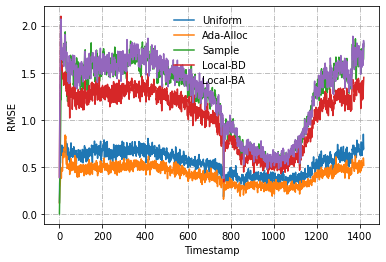

In [7]:
x = np.arange(len(uniform_util))
plt.plot(x, uniform_util, '-', label='Uniform')
plt.plot(x, ada_util, '-', label='Ada-Alloc')
plt.plot(x, sample_util, '-', label='Sample')
plt.plot(x, bd_util, '-', label='Local-BD')
plt.plot(x, ba_util, '-', label='Local-BA')
# plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.legend(frameon=False)
plt.grid(linestyle='-.')
plt.savefig('user_num.pdf')
plt.show()

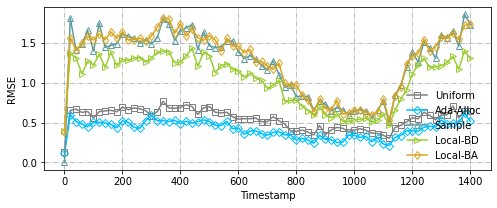

In [8]:
sample_interval = 20
plt.figure(figsize=(8, 3))
x = np.arange(0, len(uniform_util), sample_interval)
plt.plot(x, uniform_util[::sample_interval], 's-', markerfacecolor='none', label='Uniform', color='grey')
plt.plot(x, ada_util[::sample_interval], 'D-', markerfacecolor='none', label='Ada-Alloc', color='deepskyblue')
plt.plot(x, sample_util[::sample_interval], '^-', markerfacecolor='none', label='Sample', color='cadetblue')
plt.plot(x, bd_util[::sample_interval], '>-', markerfacecolor='none', label='Local-BD', color='yellowgreen')
plt.plot(x, ba_util[::sample_interval], 'd-', markerfacecolor='none', label='Local-BA', color='goldenrod')
# plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.legend(frameon=False)
plt.grid(linestyle='-.')
plt.savefig('user_num.pdf')
plt.show()

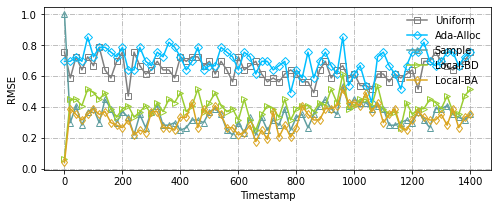

In [9]:
sample_interval = 20
plt.figure(figsize=(8, 3))
x = np.arange(0, len(uniform_js_util), sample_interval)
plt.plot(x, uniform_js_util[::sample_interval], 's-', markerfacecolor='none', label='Uniform', color='grey')
plt.plot(x, ada_js_util[::sample_interval], 'D-', markerfacecolor='none', label='Ada-Alloc', color='deepskyblue')
plt.plot(x, sample_js_util[::sample_interval], '^-', markerfacecolor='none', label='Sample', color='cadetblue')
plt.plot(x, bd_js_util[::sample_interval], '>-', markerfacecolor='none', label='Local-BD', color='yellowgreen')
plt.plot(x, ba_js_util[::sample_interval], 'd-', markerfacecolor='none', label='Local-BA', color='goldenrod')
# plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.legend(frameon=False)
plt.grid(linestyle='-.')
plt.savefig('user_num.pdf')
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


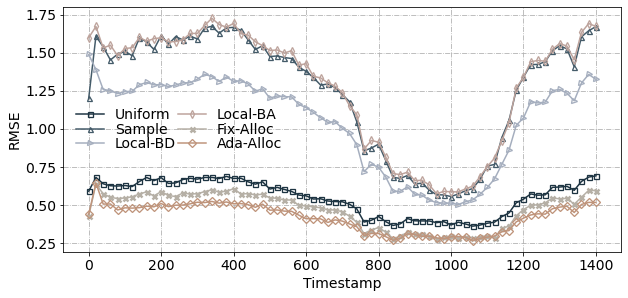

In [20]:
sample_interval = 20
plt.figure(figsize=(10, 4.5))
plt.rc('font',family='Times New Roman', size=14)
x = np.arange(0, len(uniform_util), sample_interval)
plt.plot(x, np.mean(np.array(uniform_util).reshape(-1, sample_interval), axis=1), 's-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Uniform'  , color=(29/255, 52/255, 66/255))
plt.plot(x, np.mean(np.array(sample_util).reshape(-1, sample_interval), axis=1),  '^-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Sample'   , color=(68/255, 91/255, 105/255))
plt.plot(x, np.mean(np.array(bd_util).reshape(-1, sample_interval), axis=1),      '>-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Local-BD' , color=(165/255, 174/255, 190/255))
plt.plot(x, np.mean(np.array(ba_util).reshape(-1, sample_interval), axis=1),      'd-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Local-BA' , color=(189/255, 163/255, 156/255))
plt.plot(x, np.mean(np.array(fix_util).reshape(-1, sample_interval), axis=1),     'x-', markerfacecolor='none', markersize=5, markeredgewidth=2.5, label='Fix-Alloc', color=(182/255, 176/255, 166/255))
plt.plot(x, np.mean(np.array(ada_util).reshape(-1, sample_interval), axis=1),     'D-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Ada-Alloc', color=(191/255, 148/255, 123/255))
# plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.legend(loc=0, ncol=2, columnspacing=0.1, labelspacing=0.01, frameon=False, fancybox=False, framealpha=0.5)
plt.grid(linestyle='-.')
plt.savefig('t_rmse.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

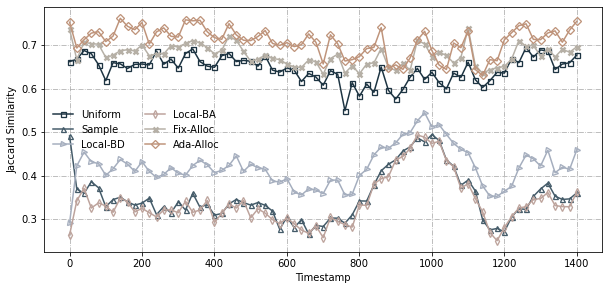

In [18]:
sample_interval = 20
plt.figure(figsize=(10, 4.5))
plt.rc('font',family='Times New Roman')
x = np.arange(0, len(uniform_util), sample_interval)
plt.plot(x, np.mean(np.array(uniform_js_util).reshape(-1, sample_interval), axis=1), 's-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Uniform'  , color=(29/255, 52/255, 66/255))
plt.plot(x, np.mean(np.array(sample_js_util).reshape(-1, sample_interval), axis=1),  '^-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Sample'   , color=(68/255, 91/255, 105/255))
plt.plot(x, np.mean(np.array(bd_js_util).reshape(-1, sample_interval), axis=1),      '>-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Local-BD' , color=(165/255, 174/255, 190/255))
plt.plot(x, np.mean(np.array(ba_js_util).reshape(-1, sample_interval), axis=1),      'd-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Local-BA' , color=(189/255, 163/255, 156/255))
plt.plot(x, np.mean(np.array(fix_js_util).reshape(-1, sample_interval), axis=1),        'x-', markerfacecolor='none', markersize=5, markeredgewidth=2.5, label='Fix-Alloc', color=(182/255, 176/255, 166/255))
plt.plot(x, np.mean(np.array(ada_js_util).reshape(-1, sample_interval), axis=1),     'D-', markerfacecolor='none', markersize=5, markeredgewidth=1.3, label='Ada-Alloc', color=(191/255, 148/255, 123/255))
# plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Jaccard Similarity')
plt.legend(ncol=2, frameon=False, fancybox=False, framealpha=0.5)
plt.grid(linestyle='-.')
plt.savefig('t_js.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

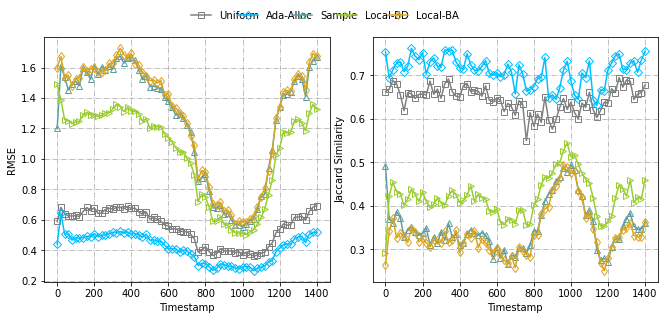

In [12]:
sample_interval = 20
plt.figure(figsize=(11, 4.5))
x = np.arange(0, len(uniform_util), sample_interval)
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.15)
plt.plot(x, np.mean(np.array(uniform_util).reshape(-1, sample_interval), axis=1), 's-', markerfacecolor='none', label='Uniform', color='grey')
plt.plot(x, np.mean(np.array(ada_util).reshape(-1, sample_interval), axis=1), 'D-', markerfacecolor='none', label='Ada-Alloc', color='deepskyblue')
plt.plot(x, np.mean(np.array(sample_util).reshape(-1, sample_interval), axis=1), '^-', markerfacecolor='none', label='Sample', color='cadetblue')
plt.plot(x, np.mean(np.array(bd_util).reshape(-1, sample_interval), axis=1), '>-', markerfacecolor='none', label='Local-BD', color='yellowgreen')
plt.plot(x, np.mean(np.array(ba_util).reshape(-1, sample_interval), axis=1), 'd-', markerfacecolor='none', label='Local-BA', color='goldenrod')
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.grid(linestyle='-.')
plt.subplot(1, 2, 2)
plt.plot(x, np.mean(np.array(uniform_js_util).reshape(-1, sample_interval), axis=1), 's-', markerfacecolor='none', label='Uniform', color='grey')
plt.plot(x, np.mean(np.array(ada_js_util).reshape(-1, sample_interval), axis=1), 'D-', markerfacecolor='none', label='Ada-Alloc', color='deepskyblue')
plt.plot(x, np.mean(np.array(sample_js_util).reshape(-1, sample_interval), axis=1), '^-', markerfacecolor='none', label='Sample', color='cadetblue')
plt.plot(x, np.mean(np.array(bd_js_util).reshape(-1, sample_interval), axis=1), '>-', markerfacecolor='none', label='Local-BD', color='yellowgreen')
plt.plot(x, np.mean(np.array(ba_js_util).reshape(-1, sample_interval), axis=1), 'd-', markerfacecolor='none', label='Local-BA', color='goldenrod')
plt.xlabel('Timestamp')
plt.ylabel('Jaccard Similarity')
plt.grid(linestyle='-.')
plt.legend(loc=(-0.65, 1.05), ncol=5, mode='expand', frameon=False)
plt.savefig('time_util.pdf', bbox_inches='tight')
plt.show()